In [1]:
import matplotlib.pyplot as plt
import torch

from cheetah import ParticleBeam, TransverseDeflectingCavity, Segment
from cheetah.utils.bmadx import bmad_to_cheetah_coords, cheetah_to_bmad_coords

import os

torch.set_printoptions(precision=15, sci_mode=True)

In [2]:
# Incoming beam
incoming = torch.load("../../tests/resources/bmadx/incoming_beam.pt")
print(f"particles shape: {incoming.particles.shape}")
print(f"energy shape: {incoming.energy.shape}")

particles shape: torch.Size([1, 10000, 7])
energy shape: torch.Size([1])


/var/folders/h2/0svjf60s08307h9svgy94lb00000gn/T/ipykernel_16949/1216992420.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  incoming = torch.load("../../tests/resources/

In [3]:
# Test if coordinate transormation is correct
from scipy.constants import physical_constants

mc2 = torch.tensor(
    physical_constants["electron mass energy equivalent in MeV"][0] * 1e6,
    dtype=torch.float64,
)
bmad_coords, p0c = cheetah_to_bmad_coords(
    incoming.particles, incoming.energy, mc2
)
test_coords, test_ref_energy = bmad_to_cheetah_coords(bmad_coords, p0c, mc2)
print(torch.allclose(incoming.energy, test_ref_energy, atol=0, rtol=1e-14))
print(torch.allclose(incoming.particles, test_coords, atol=1e-14, rtol=1e-14))

True
True


In [4]:
test_ref_energy

tensor([1.000000000000000e+08], dtype=torch.float64)

In [5]:
l = torch.tensor([1.0], dtype=torch.double)
voltage = torch.tensor(1.0e7, dtype=torch.double)
phase = torch.tensor(0.2, dtype=torch.double)
frequency = torch.tensor(1.0e9, dtype=torch.double)

# Bmad-X tracking method
cheetah_tdc_bmadx = TransverseDeflectingCavity(
    l,
    voltage,
    phase,
    frequency,
    tracking_method="bmadx",
    dtype=torch.double,
)
cheetah_bmadx_outgoing_beam = cheetah_tdc_bmadx.track(incoming)

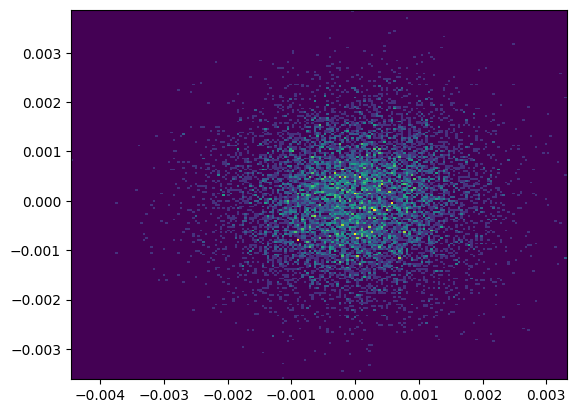

In [6]:
# Initial y-py phase space
plt.hist2d(incoming.particles[0, :, 2], incoming.particles[0, :, 3], bins=200)
plt.show()

In [7]:
cheetah_bmadx_outgoing_beam.particles[0, :, 0]

tensor([4.845032758241592e-02, 4.511829409080167e-02, 5.072109330496279e-02,
         ..., 4.849329946695340e-02, 4.617152161231548e-02,
        4.838139810654370e-02], dtype=torch.float64)

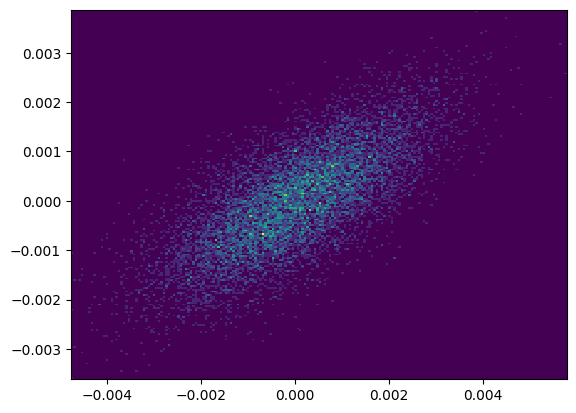

In [8]:
# Bmad-X tracking method output y-py phase space: chromatic effects:
plt.hist2d(
    cheetah_bmadx_outgoing_beam.particles[0, :, 2],
    cheetah_bmadx_outgoing_beam.particles[0, :, 3],
    bins=200,
)
plt.show()

In [9]:
# Compare against Bmad-X package
from bmadx.bmad_torch.track_torch import Beam, TorchCrabCavity, TorchLattice

bmadx_beam = Beam(data=bmad_coords, p0c=p0c, mc2=mc2)
bmadx_tdc = TorchCrabCavity(
    L=l,
    VOLTAGE=voltage,
    RF_FREQUENCY=frequency,
    PHI0=phase
)
bmadx_lattice = TorchLattice([bmadx_tdc])
bmadx_out_coords = torch.stack(bmadx_lattice(bmadx_beam)[:6], dim=-1)
bmadx_out_with_cheetah_coords, ref_energy = bmad_to_cheetah_coords(
    bmadx_out_coords, p0c, mc2
)

In [10]:
bmadx_out_coords[0,:,0]

tensor([4.845032758241592e-02, 4.511829409080167e-02, 5.072109330496279e-02,
         ..., 4.849329946695340e-02, 4.617152161231548e-02,
        4.838139810654370e-02], dtype=torch.float64)

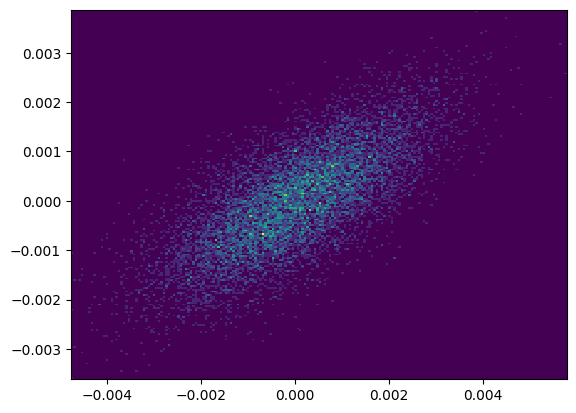

In [11]:
# Bmad-X package tracking output y-py phase space: chromatic effects:
plt.hist2d(
    bmadx_out_with_cheetah_coords[0, :, 2],
    bmadx_out_with_cheetah_coords[0, :, 3],
    bins=200,
)
plt.show()

In [12]:
# Compare against cheetah with Bmad-X tracking method (expected to be the same)
print(
    torch.allclose(
        bmadx_out_with_cheetah_coords,
        cheetah_bmadx_outgoing_beam.particles,
        atol=0,
        rtol=1e-14,
    )
)
# For some reason, Bmad-X results only agree to single precision.

True


In [16]:
# Save tensors for tests
torch.save(bmadx_out_with_cheetah_coords, "outgoing_beam_bmadx_crab_cavity.pt")